In [1]:
# initialize dependencies
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import transforms
from torch.utils.data import DataLoader
import random

torch.set_default_device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/home/od/.pyenv/versions/jup/lib/python3.13/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


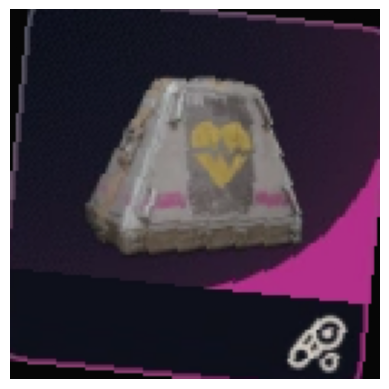

In [ ]:
# prepare datasets
# import png images from 'arc-raiders-items' folder. Label is folder name, images below are training images.
composedTransforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

train_ds = torchvision.datasets.ImageFolder(
    root="./arc-raiders-items",
    transform=composedTransforms,
    )

# validation split
val_split = 0.2
num_val = int(len(train_ds) * val_split)
num_train = len(train_ds) - num_val
train_dataset, val_dataset = torch.utils.data.random_split(train_ds, [num_train, num_val], generator=torch.Generator(device='cuda'))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, pin_memory=True, num_workers=2)

train_dataset_gpu = [(image.to(device), label) for image, label in train_dataset]

# Get the number of classes from the original dataset
num_classes = len(train_ds.classes)

# display random image from dataset to ensure it has loaded properly
index = random.randrange(0, len(train_dataset) - 1)
image, label = train_dataset_gpu[index]

import matplotlib.pyplot as plt
plt.imshow(torch.Tensor(image).cpu().permute(1, 2, 0))  # change from CxHxW to HxWxC
plt.axis("off")
plt.show()


In [16]:
# init neuralnet
net = nn.Sequential(
    nn.Conv2d(3, 32, 3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(32, 64, 3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(64, 128, 3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Flatten(),
    nn.Linear(16 * 16 * 128, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, len(train_dataset))
).cuda()

loss_fn = nn.CrossEntropyLoss() # standard loss function for multi-class classification
optimizer = torch.optim.Adam(net.parameters(), lr=0.000005) # Adam optimizer with low learning rate

In [17]:
# training loop

def evaluate(net, dataloader, criterion):
    net.eval()  # evaluation mode (no dropout, no batchnorm updates)

    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():  # no gradients needed
        for images, labels in dataloader:
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)   # sum loss * batch_size
            _, preds = outputs.max(1)

            total_correct += preds.eq(labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples

    return avg_loss, accuracy



num_epochs = 50
batch_size = 64

for epoch in range(num_epochs):
    for images, labels in train_loader:
        net.train()

        # forward pass (make a prediction)
        logits = net(images)
        loss = loss_fn(logits, labels)

        # good old fashioned back propogation 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # validation
        val_loss, val_acc = evaluate(net, val_loader, criterion)


    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

# set model to eval mode
net.eval()

RuntimeError: Expected a 'cuda' device type for generator but found 'cpu'

# mostly util stuff below this

Predicted: [120, 150, 67, 224, 177], Actual: [120, 261, 181, 27, 229]


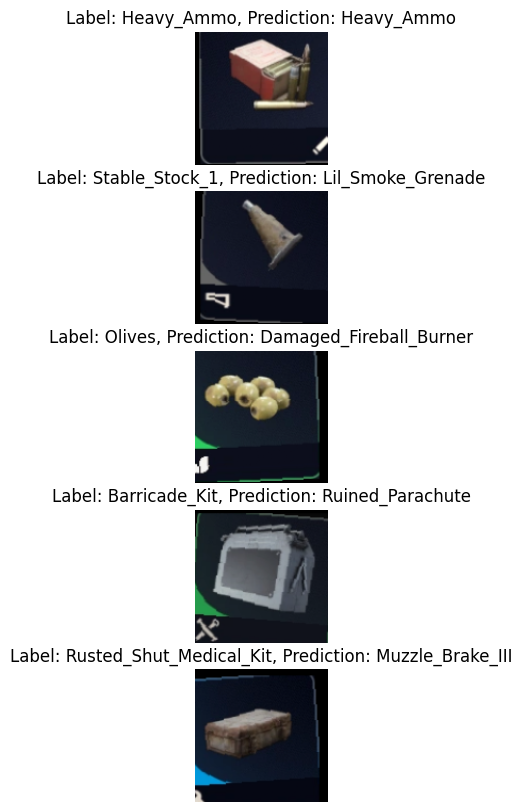

In [95]:
# predict on random images
# select random image set and predict
randomIndices = [random.randrange(0, len(train_dataset)) for _ in range(5)]
images = []
labels = []
for i in range(5):
    img, lbl = train_dataset[randomIndices[i]]
    images.append(img)
    labels.append(lbl)

# infer on GPU

images = torch.stack(images).to(device)  # create batch
logits = net(images)
predicted_labels = logits.argmax(dim=1).tolist()

# Get class names from ImageFolder
dataset_classes = torchvision.datasets.ImageFolder(root="./arc-raiders-items").classes

# visualise predictions
fig, axes = plt.subplots(5, 1, figsize=(10, 10))
print(f"Predicted: {predicted_labels}, Actual: {labels}")
cnt = 0
for ax in axes:
    img, lbl = train_dataset[randomIndices[cnt]]
    cnt += 1
    ax.imshow(img.permute(1, 2, 0).cpu())  # change from CxHxW to HxWxC
    # convert labels to category names
    train_label_name = dataset_classes[lbl]
    predicted_label_name = dataset_classes[predicted_labels[cnt-1]]
    ax.set_title(f"Label: {train_label_name}, Prediction: {predicted_label_name}")
    ax.axis("off")

In [75]:
import copy

net.eval()


# Save neural net weights
torch.save(net.state_dict(), "arcraiders_model.pth")

# save ONNX
dummy_input = torch.randn(1, 3, 128, 128)
torch.onnx.export(net, dummy_input, "arcraiders_model.onnx", opset_version=17, do_constant_folding=True)

W1130 16:42:47.001000 122487 /home/od/.pyenv/versions/3.13.9/envs/jup/lib/python3.13/site-packages/torch/onnx/_internal/exporter/_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 17 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features


[torch.onnx] Obtain model graph for `Sequential([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `Sequential([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


The model version conversion is not supported by the onnxscript version converter and fallback is enabled. The model will be converted using the onnx C API (target version: 17).


[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 3 of general pattern rewrite rules.


ONNXProgram(
    model=
        <
            ir_version=10,
            opset_imports={'': 17},
            producer_name='pytorch',
            producer_version='2.9.1+cu128',
            domain=None,
            model_version=None,
        >
        graph(
            name=main_graph,
            inputs=(
                %"input"<FLOAT,[1,3,128,128]>
            ),
            outputs=(
                %"linear_1"<FLOAT,[1,305]>
            ),
            initializers=(
                %"0.weight"<FLOAT,[32,3,3,3]>{Tensor(...)},
                %"0.bias"<FLOAT,[32]>{Tensor(...)},
                %"4.bias"<FLOAT,[64]>{Tensor(...)},
                %"8.bias"<FLOAT,[128]>{Tensor(...)},
                %"13.bias"<FLOAT,[256]>{TorchTensor(...)},
                %"16.bias"<FLOAT,[305]>{TorchTensor(...)},
                %"4.weight"<FLOAT,[64,32,3,3]>{Tensor(...)},
                %"8.weight"<FLOAT,[128,64,3,3]>{Tensor(...)},
                %"13.weight"<FLOAT,[256,32768]>{TorchTensor(...)

In [ ]:
# test CPU inference speed
import time

# import net from file init datasets
if cpu_net is None:
    cpu_net = nn.Sequential(
        nn.Flatten(),
        nn.Linear(64 * 64 * 3, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, len(dataset_classes)),
    )
    cpu_net.load_state_dict(torch.load("arcraiders_model.pth"))
    cpu_net.to("cpu")

# prepare random input
cpuRandomIndices = [random.randrange(0, len(train_dataset)) for _ in range(5)]
cpuImages = []
cpuLabels = []
for i in range(5):
    img, lbl = train_dataset[cpuRandomIndices[i]]
    cpuImages.append(img)
    cpuLabels.append(lbl)

random_input = torch.stack(cpuImages)  # create batch
# warm up
_ = cpu_net(random_input)
# measure time
start_time = time.time()
_ = cpu_net(random_input)
end_time = time.time()
print(f"CPU inference time: {end_time - start_time:.6f} seconds")

# infer on GPU

cpuImages = torch.stack(cpuImages) # create batch
cpuLogits = net(cpuImages)
cpu_predicted_labels = cpuLogits.argmax(dim=1).tolist()

# visualise predictions
fig, axes = plt.subplots(5, 1, figsize=(10, 10))
print(f"Predicted: {cpu_predicted_labels}, Actual: {cpuLabels}")
cnt = 0
for ax in axes:
    img, lbl = train_dataset[cpuRandomIndices[cnt]]
    cnt += 1
    ax.imshow(img.permute(1, 2, 0).cpu())  # change from CxHxW to HxWxC
    # convert labels to category names
    train_label_name = dataset_classes[lbl]
    predicted_label_name = dataset_classes[cpu_predicted_labels[cnt-1]]
    ax.set_title(f"Label: {train_label_name}, Prediction: {predicted_label_name}")
    ax.axis("off")

CPU inference time: 0.014972 seconds


RuntimeError: Expected all tensors to be on the same device, but got mat1 is on cpu, different from other tensors on cuda:0 (when checking argument in method wrapper_CUDA_addmm)

In [27]:
# output classes to json
import json
with open("arcraiders_classes.json", "w") as f:
    json.dump(dataset_classes, f)